In [52]:
# !pip install pyro-ppl

In [53]:
!echo "Last updated: `date`"

Last updated: Wed Aug 19 15:53:33 PDT 2020


In [54]:
# Libraries
import os
import sys
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150
import numpy as np
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS, HMC
import torch
import torch.distributions.constraints as constraints
from torch.nn.functional import pad
from tqdm import trange
from sklearn.datasets import make_moons

# For ADVI
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO
from pyro.contrib.autoguide import AutoDiagonalNormal
from pyro.optim import Adam

# For GP
import pyro.contrib.gp as gp

# Default to double precision for torch objects.
torch.set_default_dtype(torch.float64)

In [55]:
def gen_grid(X, n, return_each=False, eps=0):
    x0, x1 = np.meshgrid(np.linspace(X[:, 0].min()-eps, X[:, 0].max()+eps, n),
                         np.linspace(X[:, 1].min()-eps, X[:, 1].max()+eps, n))
    
    Y = np.stack([x0.ravel(), x1.ravel()], axis=-1)
    
    if return_each:
        return Y, x0, x1
    else:
        return Y

def predict(samples, i, X, Xnew, eps=1e-6):
    kernel = gp.kernels.RBF(2, samples['alpha'][i], samples['rho'][i])
    Nnew = Xnew.shape[0]
    
    f = compute_f(samples['alpha'][i],
                  samples['rho'][i],
                  samples['beta'][i],
                  samples['eta'][i], X)
    
    with torch.no_grad():
        gpr = gp.models.GPRegression(X, f, kernel)
        mean, cov = gpr(Xnew, full_cov=True)
        
    fhat = dist.MultivariateNormal(
        mean, cov + torch.eye(Nnew) * eps
    ).sample()
    
    return fhat.sigmoid().numpy()

def plot_data(X, y, **kwargs):
    colors = np.array(['blue', 'red'])
    plt.scatter(X[:, 0], X[:, 1], c=colors[y], **kwargs)

def plot_kernel_params(samples, algo, kernel_params=['alpha', 'rho', 'beta'],
                       figsize=(8, 3)):
    plt.figure(figsize=figsize * 1.2)
    for i in range(len(kernel_params)):
        plt.subplot(1, len(kernel_params), i + 1)
        param = kernel_params[i]
        plt.hist(samples[param], bins=30, density=True)
        plt.xlabel(param)
        plt.ylabel('density')
        plt.title(f"Histograhm of {param} ({algo})")
    plt.tight_layout()   

def plot_uq(samples, X, Xnew, algo, figsize=np.array([8, 3])):
    preds = np.stack([predict(samples, i, X, Xnew)
                    for i in trange(samples['rho'].shape[0])])
    plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.contourf(x0, x1, preds.mean(0).reshape(x0.shape), 101,
                cmap=plt.get_cmap('bwr'), vmin=0, vmax=1)
    plt.title(f'Posterior Mean function ({algo})')
    plt.xticks([]); plt.yticks([])
    plt.colorbar()
    plot_data(X, y, edgecolor="orange")

    plt.subplot(1, 2, 2)
    plt.contourf(x0, x1, preds.std(0).reshape(x0.shape), 101,
                cmap=plt.get_cmap('Oranges'), vmin=0)
    plt.title(f'Posterior SD function ({algo})')
    plt.xticks([]); plt.yticks([])
    plt.colorbar()

    plot_data(X, y, edgecolor="black")

    plot_kernel_params(samples, algo, figsize=figsize)

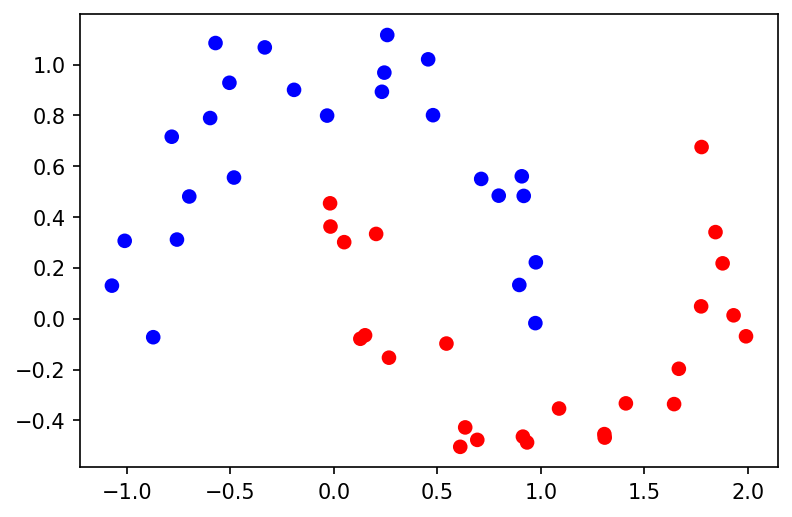

In [56]:
# Make data
# X, y = make_moons(n_samples=50, shuffle=True, noise=0.1, random_state=1)

# Read data.
simdata = json.load(open('../data/gp-classify-data-N50.json'))

X = torch.stack([torch.tensor(simdata['x1']),
                 torch.tensor(simdata['x2'])], axis=-1)
y = torch.tensor(simdata['y'])

# Make prediction grid.
Xnew, x0, x1 = gen_grid(X, 30, return_each=True, eps=0.5)
Xnew = torch.from_numpy(Xnew)

plot_data(X, y)

## Model definition

In [57]:
def sq_exp_kernel(d, alpha, rho):
    return alpha * alpha * torch.exp(-0.5 * torch.pow(d / rho, 2))

def compute_f(alpha, rho, beta, eta, X):
    N = X.shape[0]
    D = torch.cdist(X, X)
    K = sq_exp_kernel(D, alpha, rho) + torch.eye(N) * 1e-6
    L = K.cholesky()
    return L.matmul(eta) + beta

# GP Binary Classifier.
def gpc(X, y):
    N = y.shape[0]
    
    # Priors.
    alpha = pyro.sample('alpha', dist.LogNormal(0, 1))
    rho = pyro.sample('rho', dist.LogNormal(0, 1))
    beta = pyro.sample('beta', dist.Normal(0, 1))

    with pyro.plate('latent_response', N):
        eta = pyro.sample('eta', dist.Normal(0, 1))

    # Latent function.
    f = compute_f(alpha, rho, beta, eta, X)
   
    with pyro.plate('response', N):
        pyro.sample('obs', dist.Bernoulli(logits=f), obs=y)

## HMC

In [58]:
%%time

### HMC ###
pyro.clear_param_store()

# Set random seed for reproducibility.
pyro.set_rng_seed(2)

# Set up HMC sampler.
kernel = HMC(gpc, step_size=0.05, trajectory_length=1, 
             adapt_step_size=False, adapt_mass_matrix=False, jit_compile=True)
hmc = MCMC(kernel, num_samples=500, warmup_steps=500)
hmc.run(X, y.double())

# Get posterior samples
hmc_posterior_samples = hmc.get_samples()

Warmup:   0%|          | 0/1000 [00:00, ?it/s]/home/ubuntu/repo/TuringBnpBenchmarks/venv/lib/python3.6/site-packages/ipykernel_launcher.py:7: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  import sys
/home/ubuntu/repo/TuringBnpBenchmarks/venv/lib/python3.6/site-packages/pyro/poutine/subsample_messenger.py:58: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  result = torch.tensor(0., device=self.device)
Sample: 100%|██████████| 1000/1000 [00:31, 32.09it/s, step size=5.00e-02, acc. prob=0.896]

CPU times: user 1min 33s, sys: 599 ms, total: 1min 33s
Wall time: 31.2 s


100%|██████████| 500/500 [00:08<00:00, 58.94it/s]


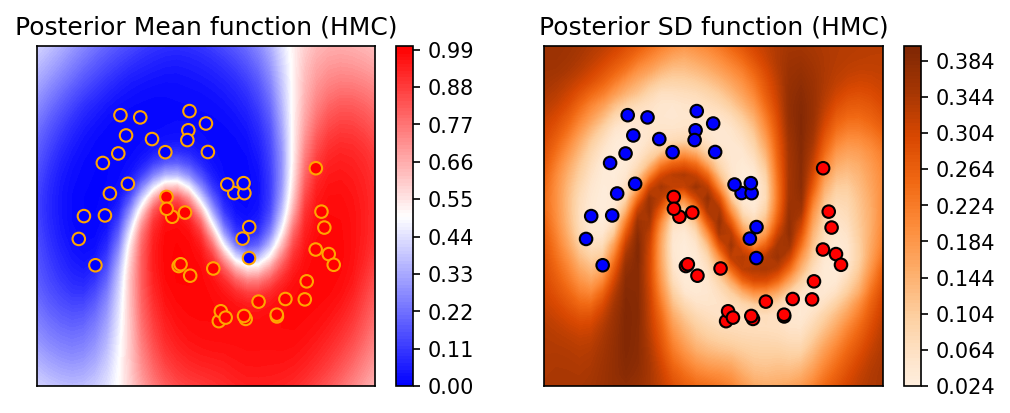

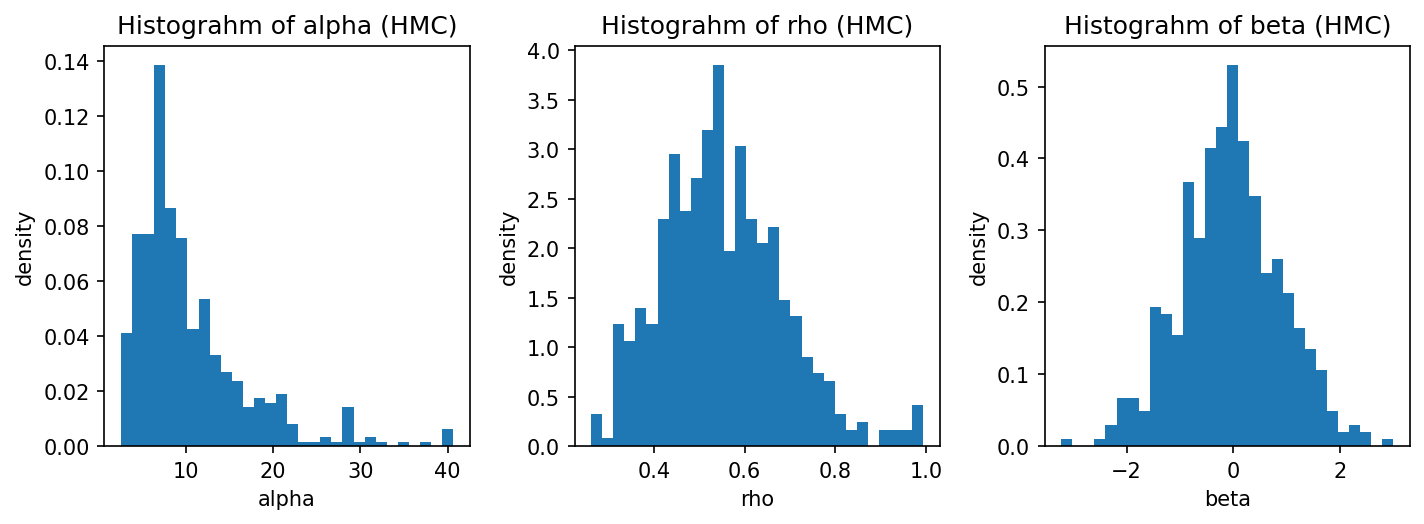

In [59]:
plot_uq(hmc_posterior_samples, X, Xnew, "HMC")

## NUTS

In [60]:
## NUTS ###
pyro.clear_param_store() 
pyro.set_rng_seed(2)

nuts = MCMC(NUTS(gpc, target_accept_prob=0.8, max_tree_depth=10,
                 jit_compile=True),
            num_samples=500, warmup_steps=500)
nuts.run(X, y.double())

nuts_posterior_samples = nuts.get_samples()

Warmup:   0%|          | 0/1000 [00:00, ?it/s]/home/ubuntu/repo/TuringBnpBenchmarks/venv/lib/python3.6/site-packages/ipykernel_launcher.py:7: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  import sys
/home/ubuntu/repo/TuringBnpBenchmarks/venv/lib/python3.6/site-packages/pyro/poutine/subsample_messenger.py:58: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  result = torch.tensor(0., device=self.device)
Sample: 100%|██████████| 1000/1000 [01:13, 13.58it/s, step size=1.56e-01, acc. prob=0.884]


100%|██████████| 500/500 [00:07<00:00, 65.57it/s]


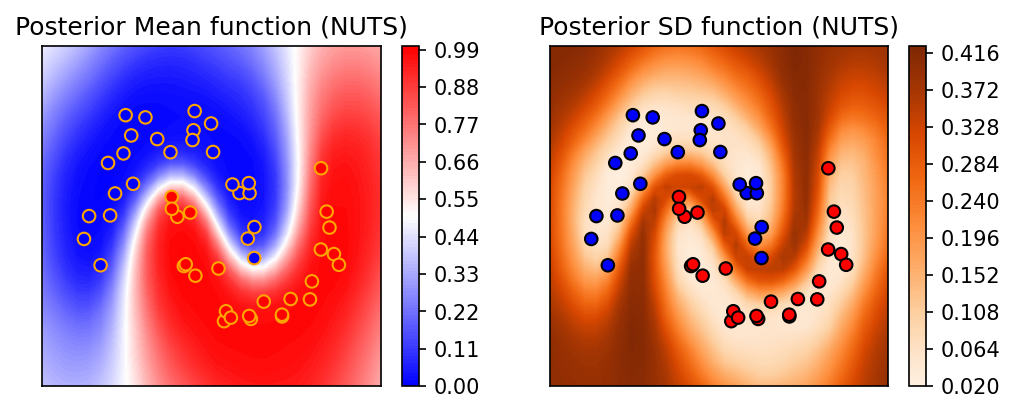

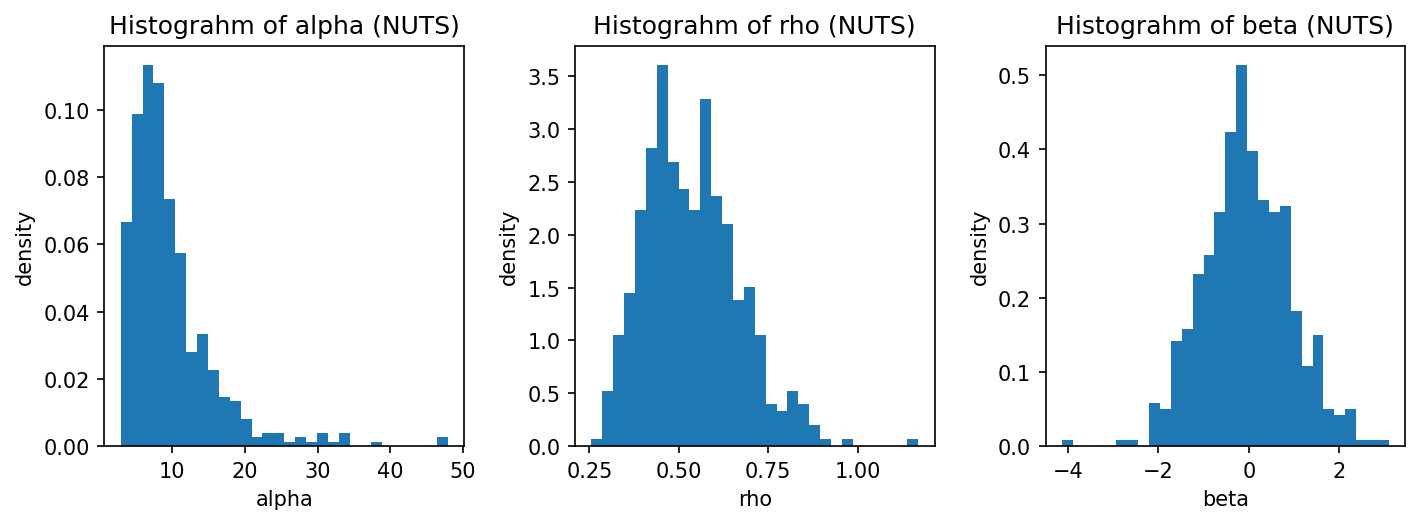

In [61]:
plot_uq(nuts_posterior_samples, X, Xnew, "NUTS")

## ADVI

100%|██████████| 1000/1000 [00:05<00:00, 181.27it/s]


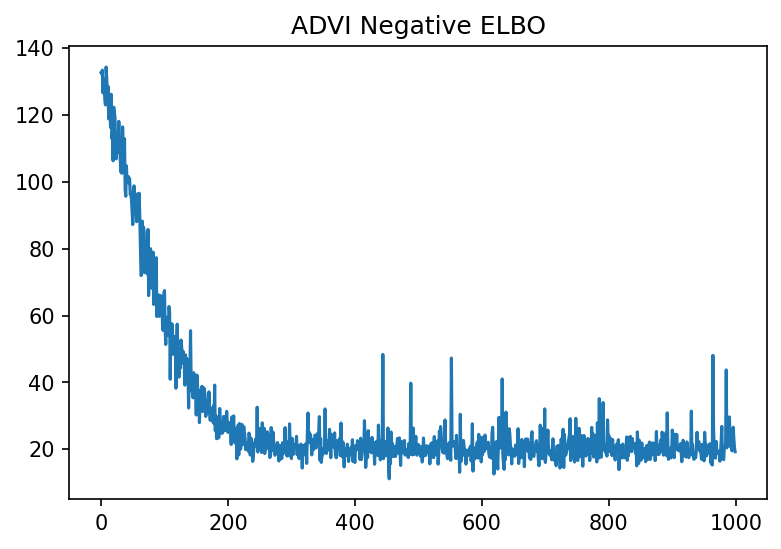

In [81]:
# Automatically define variational distribution (a mean field guide).
pyro.clear_param_store()  # clear global parameter cache
pyro.set_rng_seed(1)  # set random seed

# Create guides.
guide = AutoDiagonalNormal(gpc)

# Create SVI object for optimization.
svi = SVI(gpc, guide, Adam({'lr': 1e-2}), TraceEnum_ELBO())

# Do gradient steps.
advi_loss = []
for step in trange(1000):
    advi_loss.append(svi.step(X, y.double()))

# Plot negative ELBO trace.
plt.plot(advi_loss)
plt.title("ADVI Negative ELBO");

# Bijector for advi samples.
def biject(samples):
    return dict(alpha=samples[:, 0].exp(),
                rho=samples[:, 1].exp(),
                beta=samples[:, 2],
                eta=samples[:, 3:])

# Get ADVI samples in constrained space.
advi_samples = biject(guide.get_posterior().sample((500, )))

100%|██████████| 500/500 [00:07<00:00, 63.78it/s]


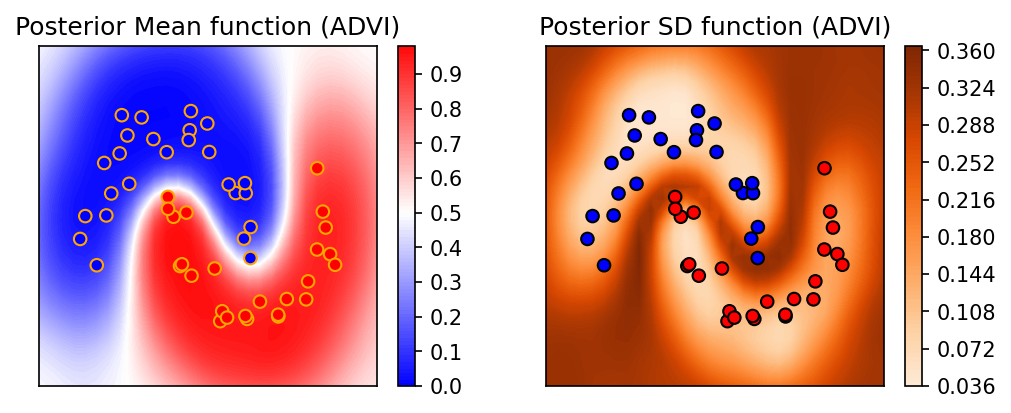

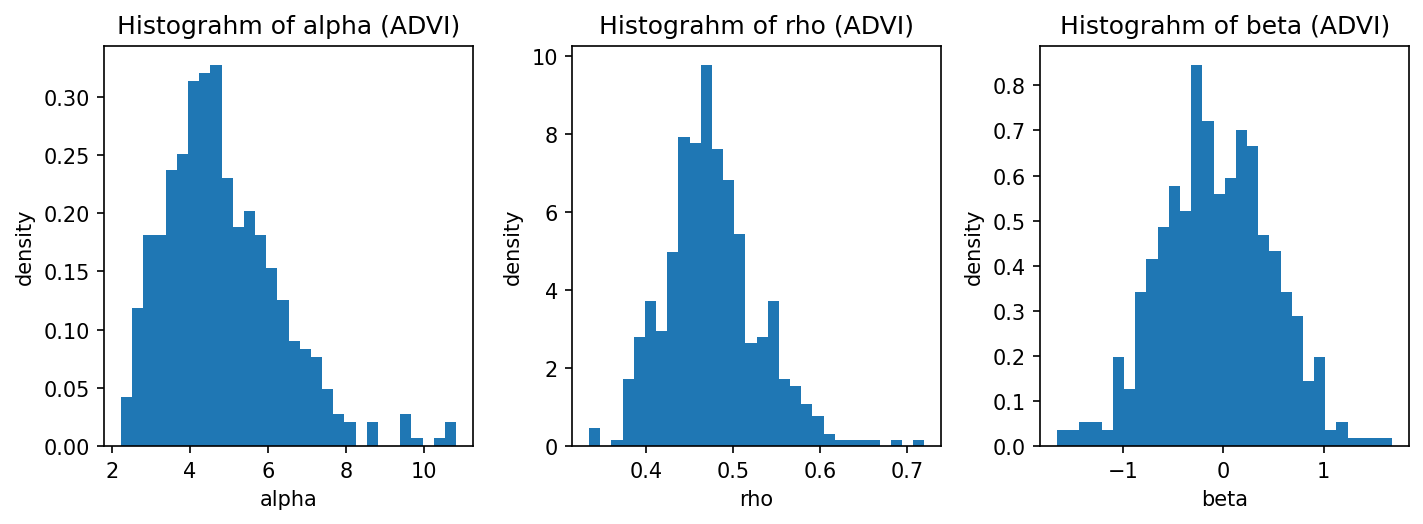

In [73]:
plot_uq(advi_samples, X, Xnew, "ADVI")